In [ ]:
"""
This script automates the process of running a time series forecasting experiment using diffrent models such as "PatchTST", "iTransformer", "TimesNet", "LSTM", "TimeLLM", "TFT", etc.
It is designed to vary the random seed parameter (from 1 to 10) to capture variability in training outcomes and assess the robustness of the model's performance across different initializations.
"""

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from typing import Union
import warnings
from datetime import datetime
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from neuralforecast.core import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.losses.pytorch import MAE, MSE
import argparse
import sys
import os
from Data.Data_Generator_ILI_HHS_TimeSplit import prepare_ILI_data
from Utils import drop_last_n_samples, splitter
import contextlib
import io
import pytorch_lightning as pl
import logging
import warnings
import os
os.environ["NIXTLA_ID_AS_COL"] = "True"

path_to_data = "Data/ILINet.csv"
test_size = 0.2
train_df, test_df, df, data, number_of_time_series, length_time_series, forecasting_horizon, number_of_samples_in_test = prepare_ILI_data(path_to_data, test_size)



/sfs/weka/scratch/jrp5td/ILI_1to4_weeks/Data/Data_Generator_ILI_HHS_TimeSplit.py:22: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = data.fillna(data.mean())
/sfs/weka/scratch/jrp5td/ILI_1to4_weeks/Data/Data_Generator_ILI_HHS_TimeSplit.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'y'] = df['y'].astype(float)


In [2]:
data

,YEAR,WEEK,REGION,% WEIGHTED ILI,Indicator,DATE
0,2005,46,Region 1,0.905434,1,2005-11-14
1,2005,47,Region 1,1.012450,2,2005-11-21
2,2005,48,Region 1,0.835424,3,2005-11-28
3,2005,49,Region 1,1.093970,4,2005-12-05
4,2005,50,Region 1,0.995161,5,2005-12-12
...,...,...,...,...,...,...
9995,2024,50,Region 9,5.010590,996,2024-12-09
9996,2024,51,Region 9,6.326640,997,2024-12-16
9997,2024,52,Region 9,8.672490,998,2024-12-23
9998,2025,1,Region 9,8.003280,999,2025-01-06


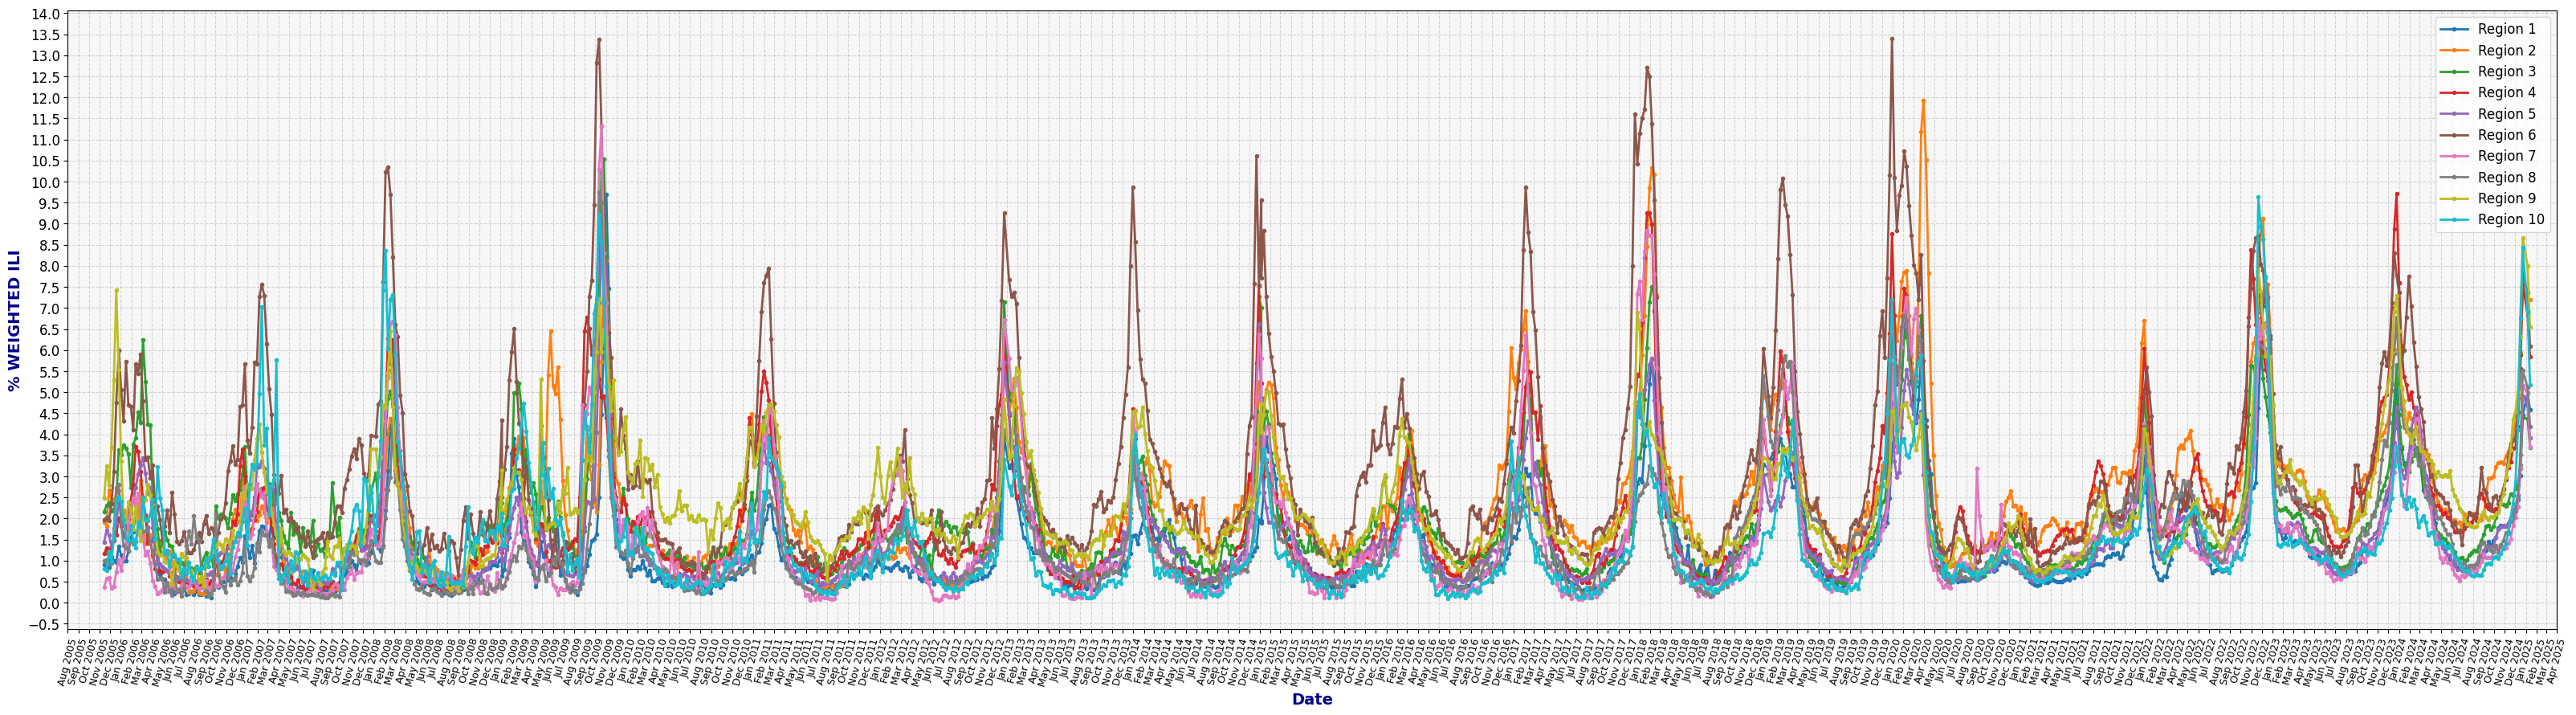

In [5]:
import matplotlib.dates as mdates

# Ensure DATE column is datetime
data['DATE'] = pd.to_datetime(data['DATE'])

plt.figure(figsize=(40, 10))

for region in ['Region 1', 'Region 2', 'Region 3', 'Region 4', 'Region 5', 'Region 6', 'Region 7', 'Region 8', 'Region 9', 'Region 10']:
    df_filtered = df[df['unique_id'] == region]
    data_filtered = data[data['REGION'] == region]
    plt.plot(data_filtered['DATE'], df_filtered['y'], marker='o', linestyle='-', linewidth=2, markersize=3, label=f'{region}')

plt.xlabel("Date", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("% WEIGHTED ILI", fontsize=14, fontweight='bold', color='darkblue')
plt.grid(True, linestyle="--", alpha=0.5)
plt.gca().set_facecolor("#f7f7f7")

# Format x-axis ticks to show only months
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., Jan, Feb, ...


# Set x-axis limits to remove margin
plt.xlim([pd.to_datetime('2005-08-01'), pd.to_datetime('2025-04-01')])


# Rotate the labels
plt.xticks(rotation=75, fontsize=9, color='black')
plt.yticks(fontsize=12, color='black')

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.legend(fontsize=12, loc='upper right')
plt.savefig("plot2.png", dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_550235/1216428441.py:71: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = polys.geometry.unary_union.centroid
/tmp/ipykernel_550235/1216428441.py:71: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = polys.geometry.unary_union.centroid
/tmp/ipykernel_550235/1216428441.py:71: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = polys.geometry.unary_union.centroid
/tmp/ipykernel_550235/1216428441.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


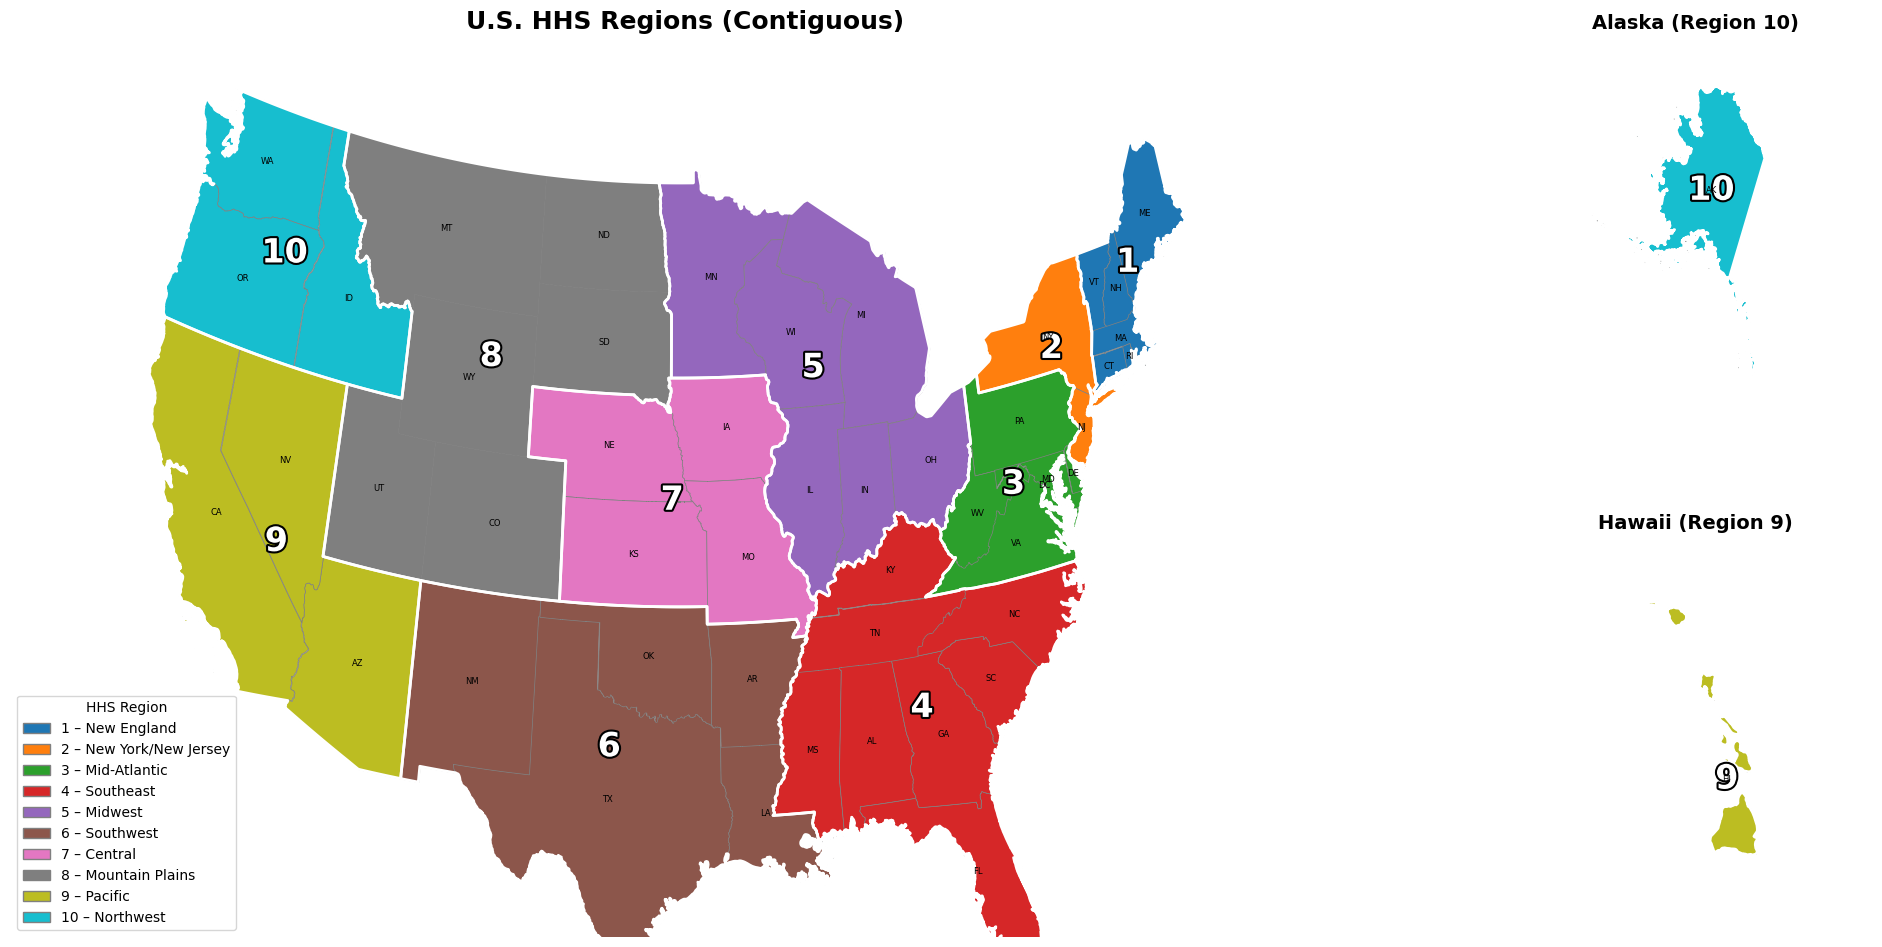

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.io.shapereader import natural_earth
import cartopy.crs as ccrs
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Patch

# — Prepare the data —
shp_path = natural_earth(resolution='10m',
                         category='cultural',
                         name='admin_1_states_provinces')
all_states = gpd.read_file(shp_path)
us = all_states[all_states['admin']=='United States of America'].copy()
us = us[~us['postal'].isin(['GU','PR','VI','MP','AS','UM'])]

region_mapping = {
    1: dict(sts=["CT","MA","ME","NH","RI","VT"],       name="New England"),
    2: dict(sts=["NJ","NY"],                           name="New York/New Jersey"),
    3: dict(sts=["DE","DC","MD","PA","VA","WV"],       name="Mid-Atlantic"),
    4: dict(sts=["AL","FL","GA","KY","MS","NC","SC","TN"], name="Southeast"),
    5: dict(sts=["IL","IN","MI","MN","OH","WI"],        name="Midwest"),
    6: dict(sts=["AR","LA","NM","OK","TX"],             name="Southwest"),
    7: dict(sts=["IA","KS","MO","NE"],                  name="Central"),
    8: dict(sts=["CO","MT","ND","SD","UT","WY"],        name="Mountain Plains"),
    9: dict(sts=["AZ","CA","HI","NV"],                  name="Pacific"),
   10: dict(sts=["AK","ID","OR","WA"],                  name="Northwest")
}
abbr2reg = {st: r for r,info in region_mapping.items() for st in info['sts']}
us['HHS_region'] = us['postal'].map(abbr2reg)
regions = us.dissolve(by='HHS_region')
cmap = plt.get_cmap('tab10')

# — Build a wide figure with 3 axes —
fig = plt.figure(figsize=(20, 10))

ax_main = fig.add_axes([0.00, 0.05, 0.75, 0.90],
                       projection=ccrs.LambertConformal())
ax_main.set_extent([-125, -66.5, 24, 50], crs=ccrs.Geodetic())

ax_ak = fig.add_axes([0.78, 0.55, 0.20, 0.40],
                     projection=ccrs.LambertConformal())
ax_ak.set_extent([-170, -130, 50, 72], crs=ccrs.Geodetic())

ax_hi = fig.add_axes([0.78, 0.05, 0.20, 0.40],
                     projection=ccrs.LambertConformal())
ax_hi.set_extent([-161, -154, 18, 23], crs=ccrs.Geodetic())

# — Helper to draw one panel —
def draw_region(ax, subset_states):
    # fill each state
    for _, row in subset_states.iterrows():
        rid = int(row['HHS_region'])
        gpd.GeoSeries(row.geometry).plot(
            ax=ax,
            facecolor=cmap(rid-1),
            edgecolor='gray',
            linewidth=0.5,
            transform=ccrs.Geodetic()
        )
    # white margins
    reg_ids = subset_states['HHS_region'].unique().tolist()
    regions.loc[reg_ids].boundary.plot(
        ax=ax,
        edgecolor='white',
        linewidth=2,
        transform=ccrs.Geodetic()
    )
    # region numbers
    for rid in reg_ids:
        polys = subset_states[subset_states['HHS_region']==rid]
        centroid = polys.geometry.unary_union.centroid
        txt = ax.text(centroid.x, centroid.y, str(rid),
                      transform=ccrs.Geodetic(),
                      fontsize=24, fontweight='bold',
                      ha='center', va='center', color='white')
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])
    # state labels
    for _, row in subset_states.iterrows():
        x, y = row.geometry.centroid.coords[0]
        ax.text(x, y, row['postal'],
                transform=ccrs.Geodetic(),
                fontsize=6, ha='center', va='center')

# — Draw panels —
contig = us[~us['postal'].isin(['AK','HI'])]
draw_region(ax_main, contig)

# — Manual legend on main —
handles = [
    Patch(facecolor=cmap(r-1), edgecolor='gray', label=f"{r} – {region_mapping[r]['name']}")
    for r in sorted(region_mapping)
]
ax_main.legend(handles=handles, title="HHS Region", loc='lower left')
ax_main.set_title("U.S. HHS Regions (Contiguous)", fontsize=18, fontweight='bold')
ax_main.axis('off')

draw_region(ax_ak, us[us['postal']=='AK'])
ax_ak.set_title("Alaska (Region 10)", fontsize=14, fontweight='bold')
ax_ak.axis('off')

draw_region(ax_hi, us[us['postal']=='HI'])
ax_hi.set_title("Hawaii (Region 9)", fontsize=14, fontweight='bold')
ax_hi.axis('off')

plt.tight_layout()
plt.show()


/tmp/ipykernel_550235/3932735891.py:65: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = polys.geometry.unary_union.centroid
/tmp/ipykernel_550235/3932735891.py:65: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = polys.geometry.unary_union.centroid
/tmp/ipykernel_550235/3932735891.py:65: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = polys.geometry.unary_union.centroid
/tmp/ipykernel_550235/3932735891.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


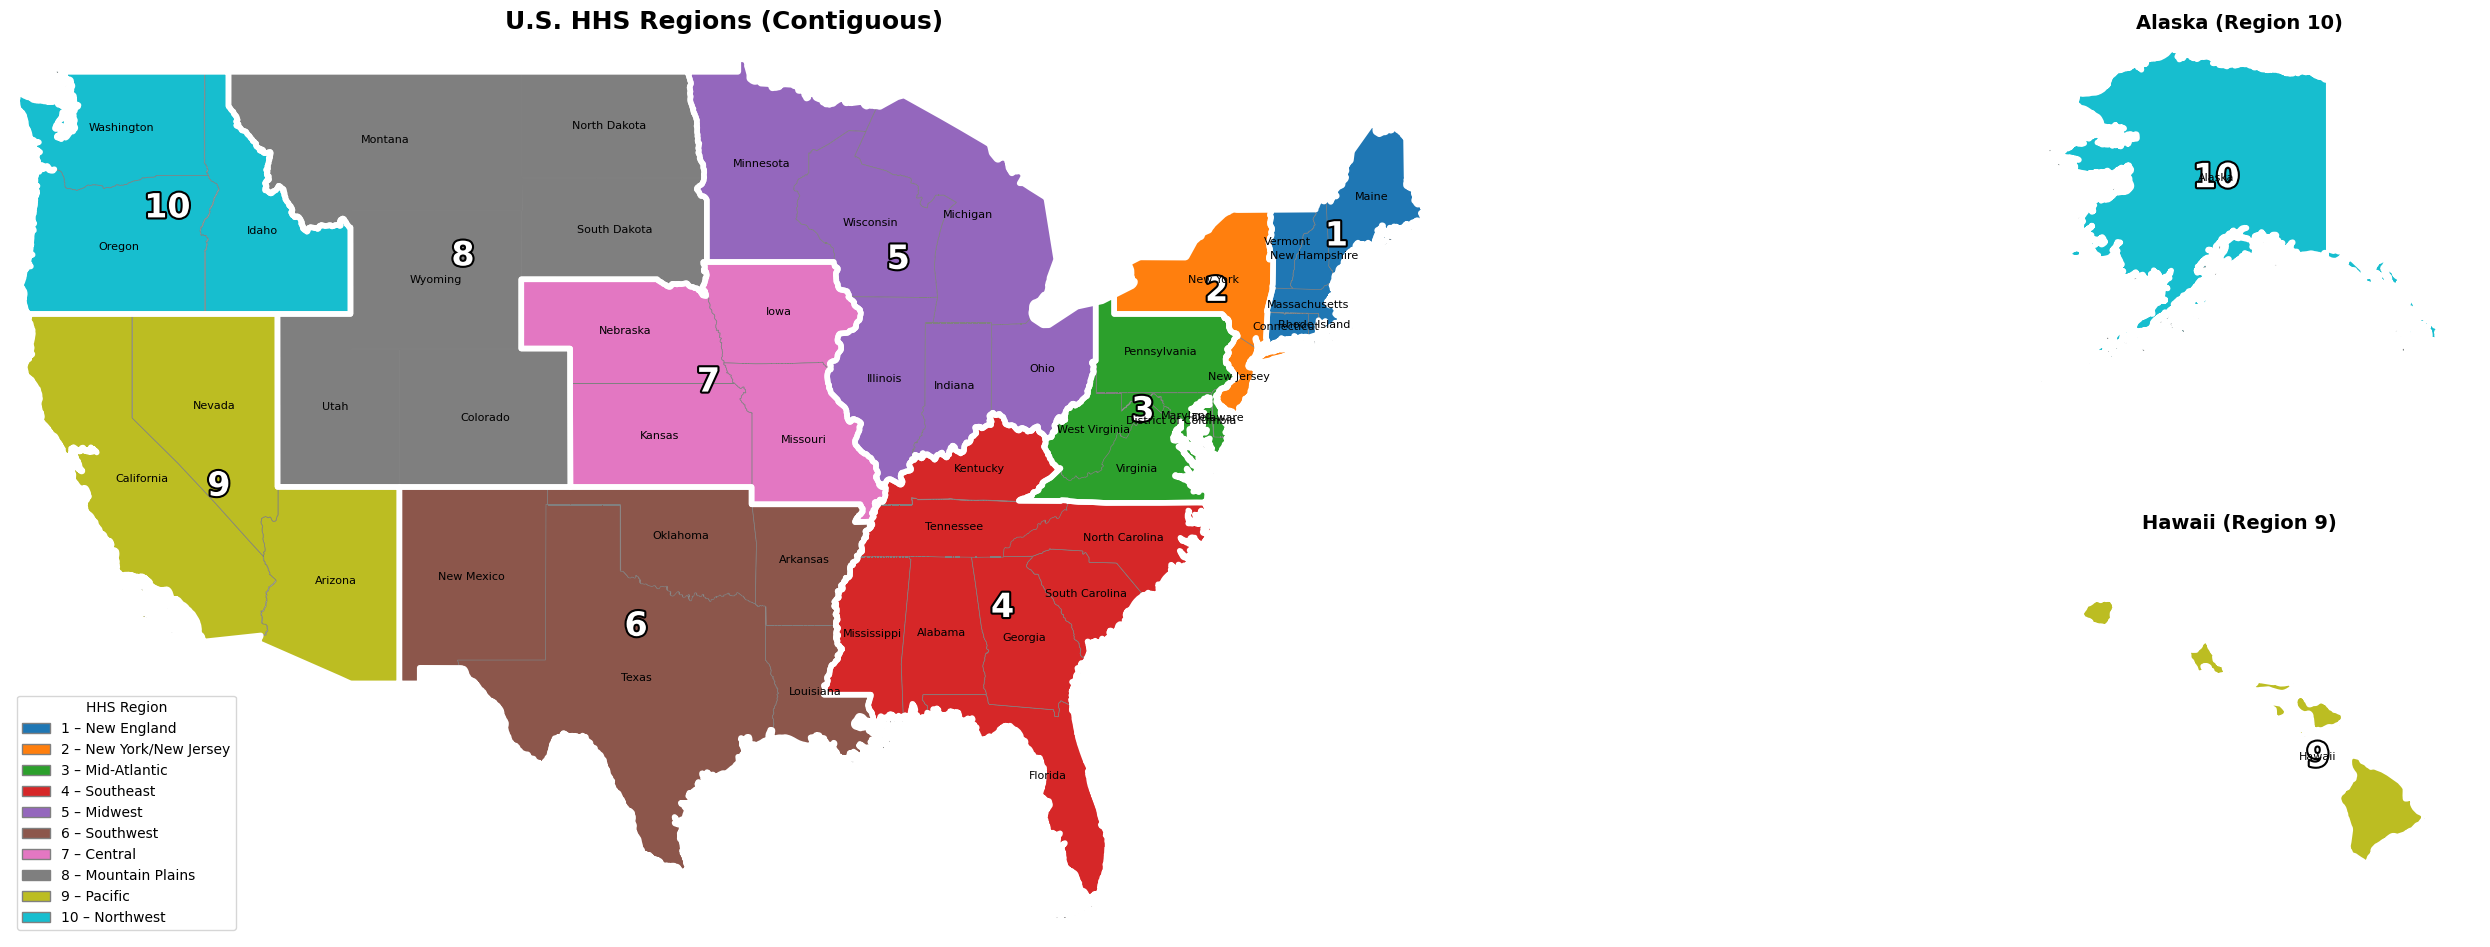

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.io.shapereader import natural_earth
import cartopy.crs as ccrs
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Patch

# — Prepare data as before…
shp_path = natural_earth(resolution='10m',
                         category='cultural',
                         name='admin_1_states_provinces')
all_states = gpd.read_file(shp_path)
us = all_states[all_states['admin']=='United States of America'].copy()
us = us[~us['postal'].isin(['GU','PR','VI','MP','AS','UM'])]

region_mapping = {
    1: dict(sts=["CT","MA","ME","NH","RI","VT"],       name="New England"),
    2: dict(sts=["NJ","NY"],                           name="New York/New Jersey"),
    3: dict(sts=["DE","DC","MD","PA","VA","WV"],       name="Mid-Atlantic"),
    4: dict(sts=["AL","FL","GA","KY","MS","NC","SC","TN"], name="Southeast"),
    5: dict(sts=["IL","IN","MI","MN","OH","WI"],        name="Midwest"),
    6: dict(sts=["AR","LA","NM","OK","TX"],             name="Southwest"),
    7: dict(sts=["IA","KS","MO","NE"],                  name="Central"),
    8: dict(sts=["CO","MT","ND","SD","UT","WY"],        name="Mountain Plains"),
    9: dict(sts=["AZ","CA","HI","NV"],                  name="Pacific"),
   10: dict(sts=["AK","ID","OR","WA"],                  name="Northwest")
}
abbr2reg = {st: r for r,info in region_mapping.items() for st in info['sts']}
us['HHS_region'] = us['postal'].map(abbr2reg)
regions = us.dissolve(by='HHS_region')
cmap = plt.get_cmap('tab10')

# — Build a wide figure with 3 axes, all PlateCarree! —
fig = plt.figure(figsize=(30, 10))

ax_main = fig.add_axes([0.00, 0.05, 0.75, 0.90],
                       projection=ccrs.PlateCarree())
ax_main.set_extent([-125, -66.5, 24, 50], crs=ccrs.PlateCarree())

ax_ak = fig.add_axes([0.78, 0.55, 0.20, 0.40],
                     projection=ccrs.PlateCarree())
ax_ak.set_extent([-170, -130, 50, 72], crs=ccrs.PlateCarree())

ax_hi = fig.add_axes([0.78, 0.05, 0.20, 0.40],
                     projection=ccrs.PlateCarree())
ax_hi.set_extent([-161, -154, 18, 23], crs=ccrs.PlateCarree())

def draw_region(ax, subset_states):
    for _, row in subset_states.iterrows():
        rid = int(row['HHS_region'])
        gpd.GeoSeries(row.geometry).plot(
            ax=ax,
            facecolor=cmap(rid-1),
            edgecolor='gray',
            linewidth=0.5,
            transform=ccrs.PlateCarree()
        )
    reg_ids = subset_states['HHS_region'].unique().tolist()
    regions.loc[reg_ids].boundary.plot(
        ax=ax, edgecolor='white', linewidth=4,
        transform=ccrs.PlateCarree()
    )
    for rid in reg_ids:
        polys = subset_states[subset_states['HHS_region']==rid]
        centroid = polys.geometry.unary_union.centroid
        txt = ax.text(centroid.x, centroid.y, str(rid),
                      transform=ccrs.PlateCarree(),
                      fontsize=24, fontweight='bold',
                      ha='center', va='center', color='white')
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])
    for _, row in subset_states.iterrows():
        x, y = row.geometry.centroid.coords[0]
        ax.text(
            x, y,                 # label position
            row['name'],          # full state name
            transform=ccrs.PlateCarree(),
            fontsize=8,           # smaller font to reduce overlap
            ha='center', va='center'
        )

# Draw everything
contig = us[~us['postal'].isin(['AK','HI'])]
draw_region(ax_main, contig)
handles = [Patch(facecolor=cmap(r-1), edgecolor='gray', label=f"{r} – {region_mapping[r]['name']}") 
           for r in sorted(region_mapping)]
ax_main.legend(handles=handles, title="HHS Region", loc='lower left')
ax_main.set_title("U.S. HHS Regions (Contiguous)", fontsize=18, fontweight='bold')
ax_main.axis('off')

draw_region(ax_ak, us[us['postal']=='AK'])
ax_ak.set_title("Alaska (Region 10)", fontsize=14, fontweight='bold')
ax_ak.axis('off')

draw_region(ax_hi, us[us['postal']=='HI'])
ax_hi.set_title("Hawaii (Region 9)", fontsize=14, fontweight='bold')
ax_hi.axis('off')

plt.tight_layout()
plt.savefig("plot3.png", dpi=300, bbox_inches='tight')
plt.show()
